In [1]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

# 04/22/2025

# Continuing the examination of the PKPD curves of different weight groups to figure out where the bug is

<br>

---

<br>

# Objective 1: Creating PKPD curves for weight groups > 15, > 25, > 35 and <= 35
<br>

---
    
# Using previously calibrated --pmax_artemether 0.9999994 and --ec50_lum 64 values

--- 

### Function call to examine state values of one weight group

In [23]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

### Weight: 10 Kg

In [27]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40]

weight_values = [10]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:05.125844 


The failed treatment count for weight 10kg is: 4060

The percentage efficacy for weight 10kg is: 18.799999999999997 



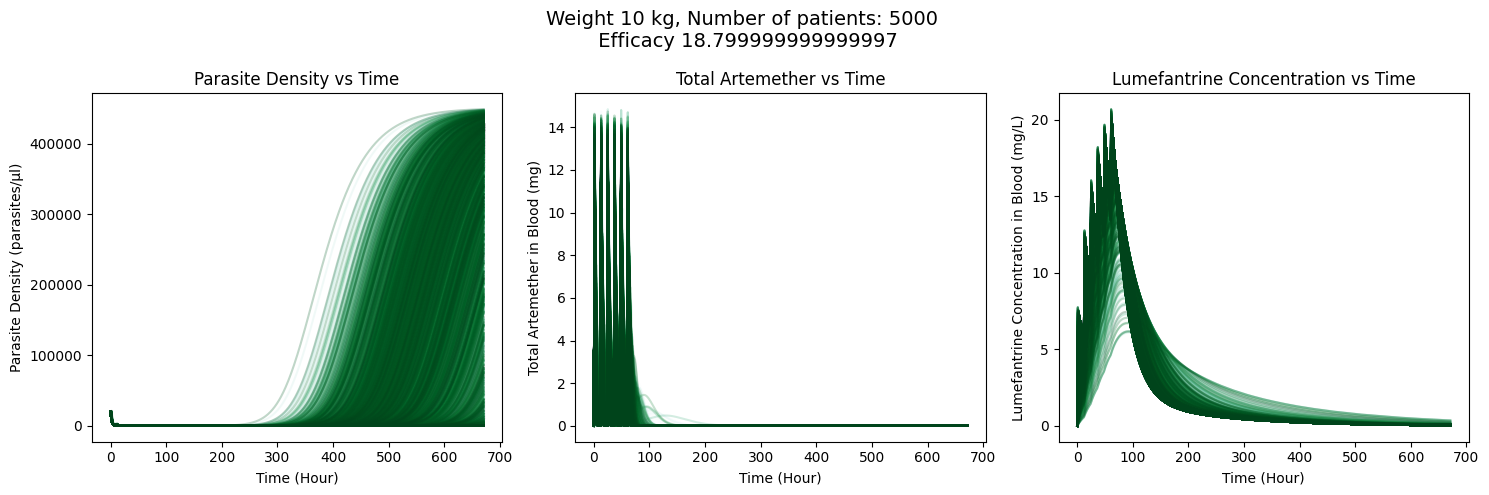

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 20 Kg

In [33]:
weight_values = [20]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:12.525941 


The failed treatment count for weight 20kg is: 2117

The percentage efficacy for weight 20kg is: 57.66 



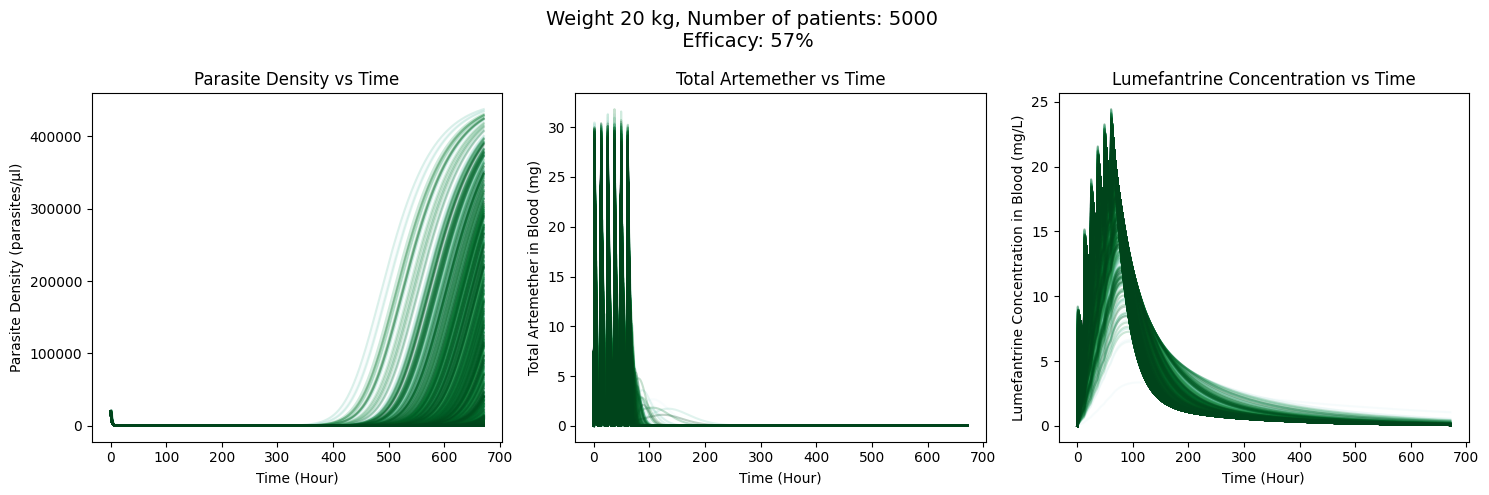

In [37]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 30 Kg

In [38]:
weight_values = [30]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:08.192839 


The failed treatment count for weight 30kg is: 892

The percentage efficacy for weight 30kg is: 82.16 



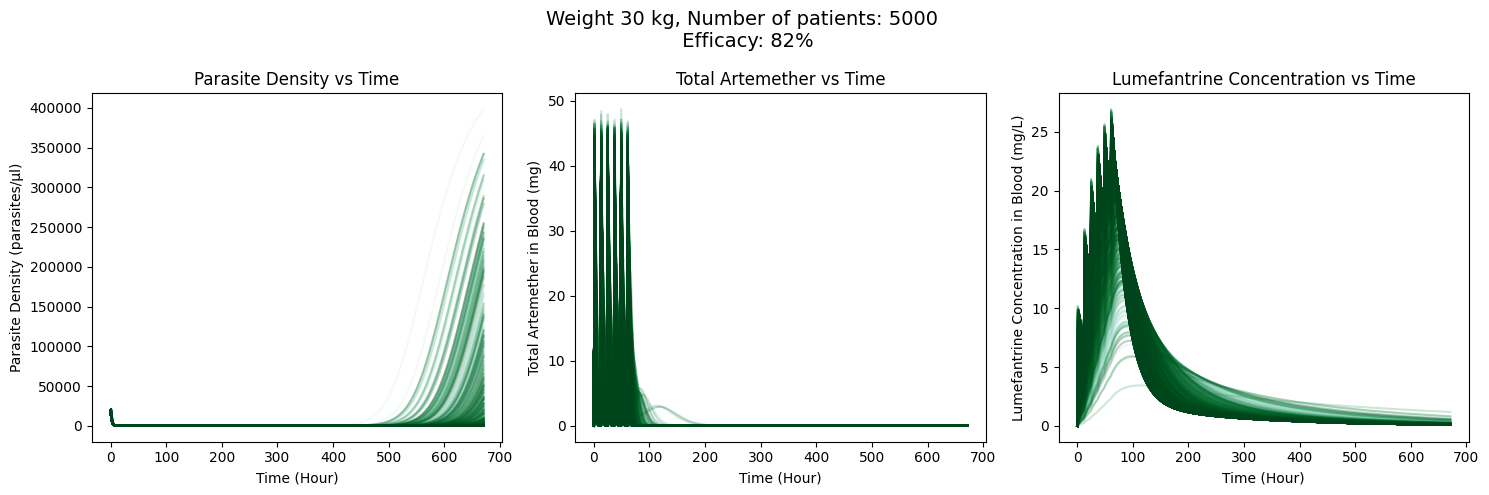

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()


<br>

### Weight: 40 Kg

In [40]:
weight_values = [40]

for weight in weight_values:
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-04-22 

Length of simulation:  0:02:07.567421 


The failed treatment count for weight 40kg is: 318

The percentage efficacy for weight 40kg is: 93.64 



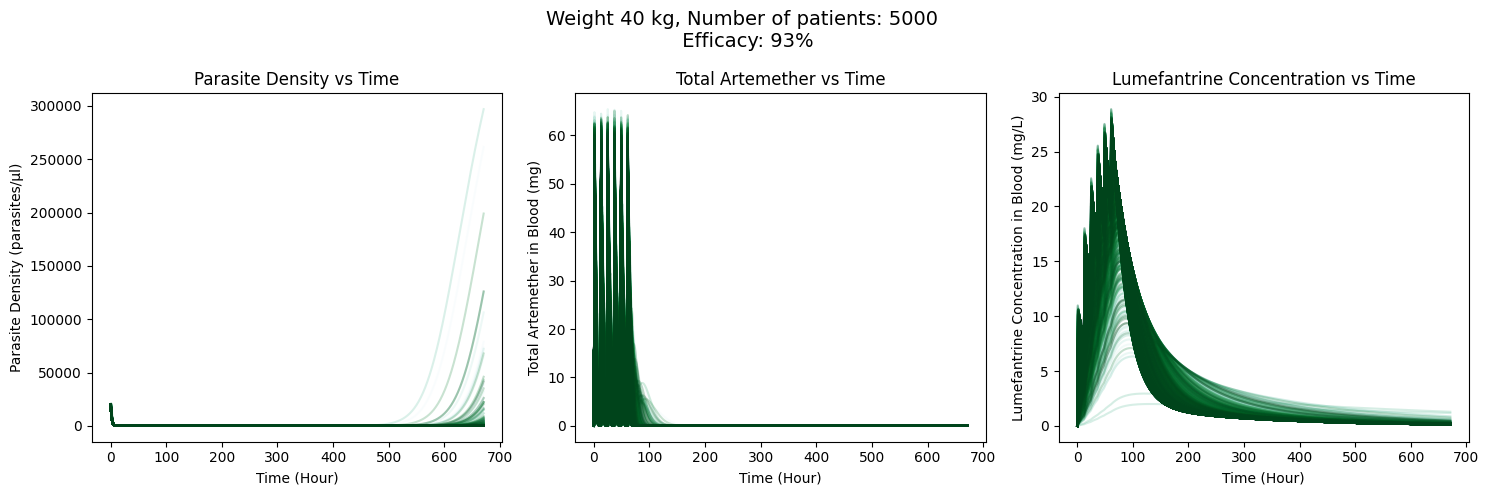

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Total Artemether in Blood (mg)')
plt.title('Total Artemether vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration in Blood (mg/L)')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids} \n Efficacy: {floor(efficacy)}%", fontsize=14)
plt.tight_layout()
plt.savefig(f"df_weight_{weight}kg.png")
plt.show()

In [2]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv("efficacy_results_compiled.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle("efficacy_results_compiled.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                    4060     18.80
1      20                    2117     57.66
2      30                     892     82.16
3      40                     318     93.64


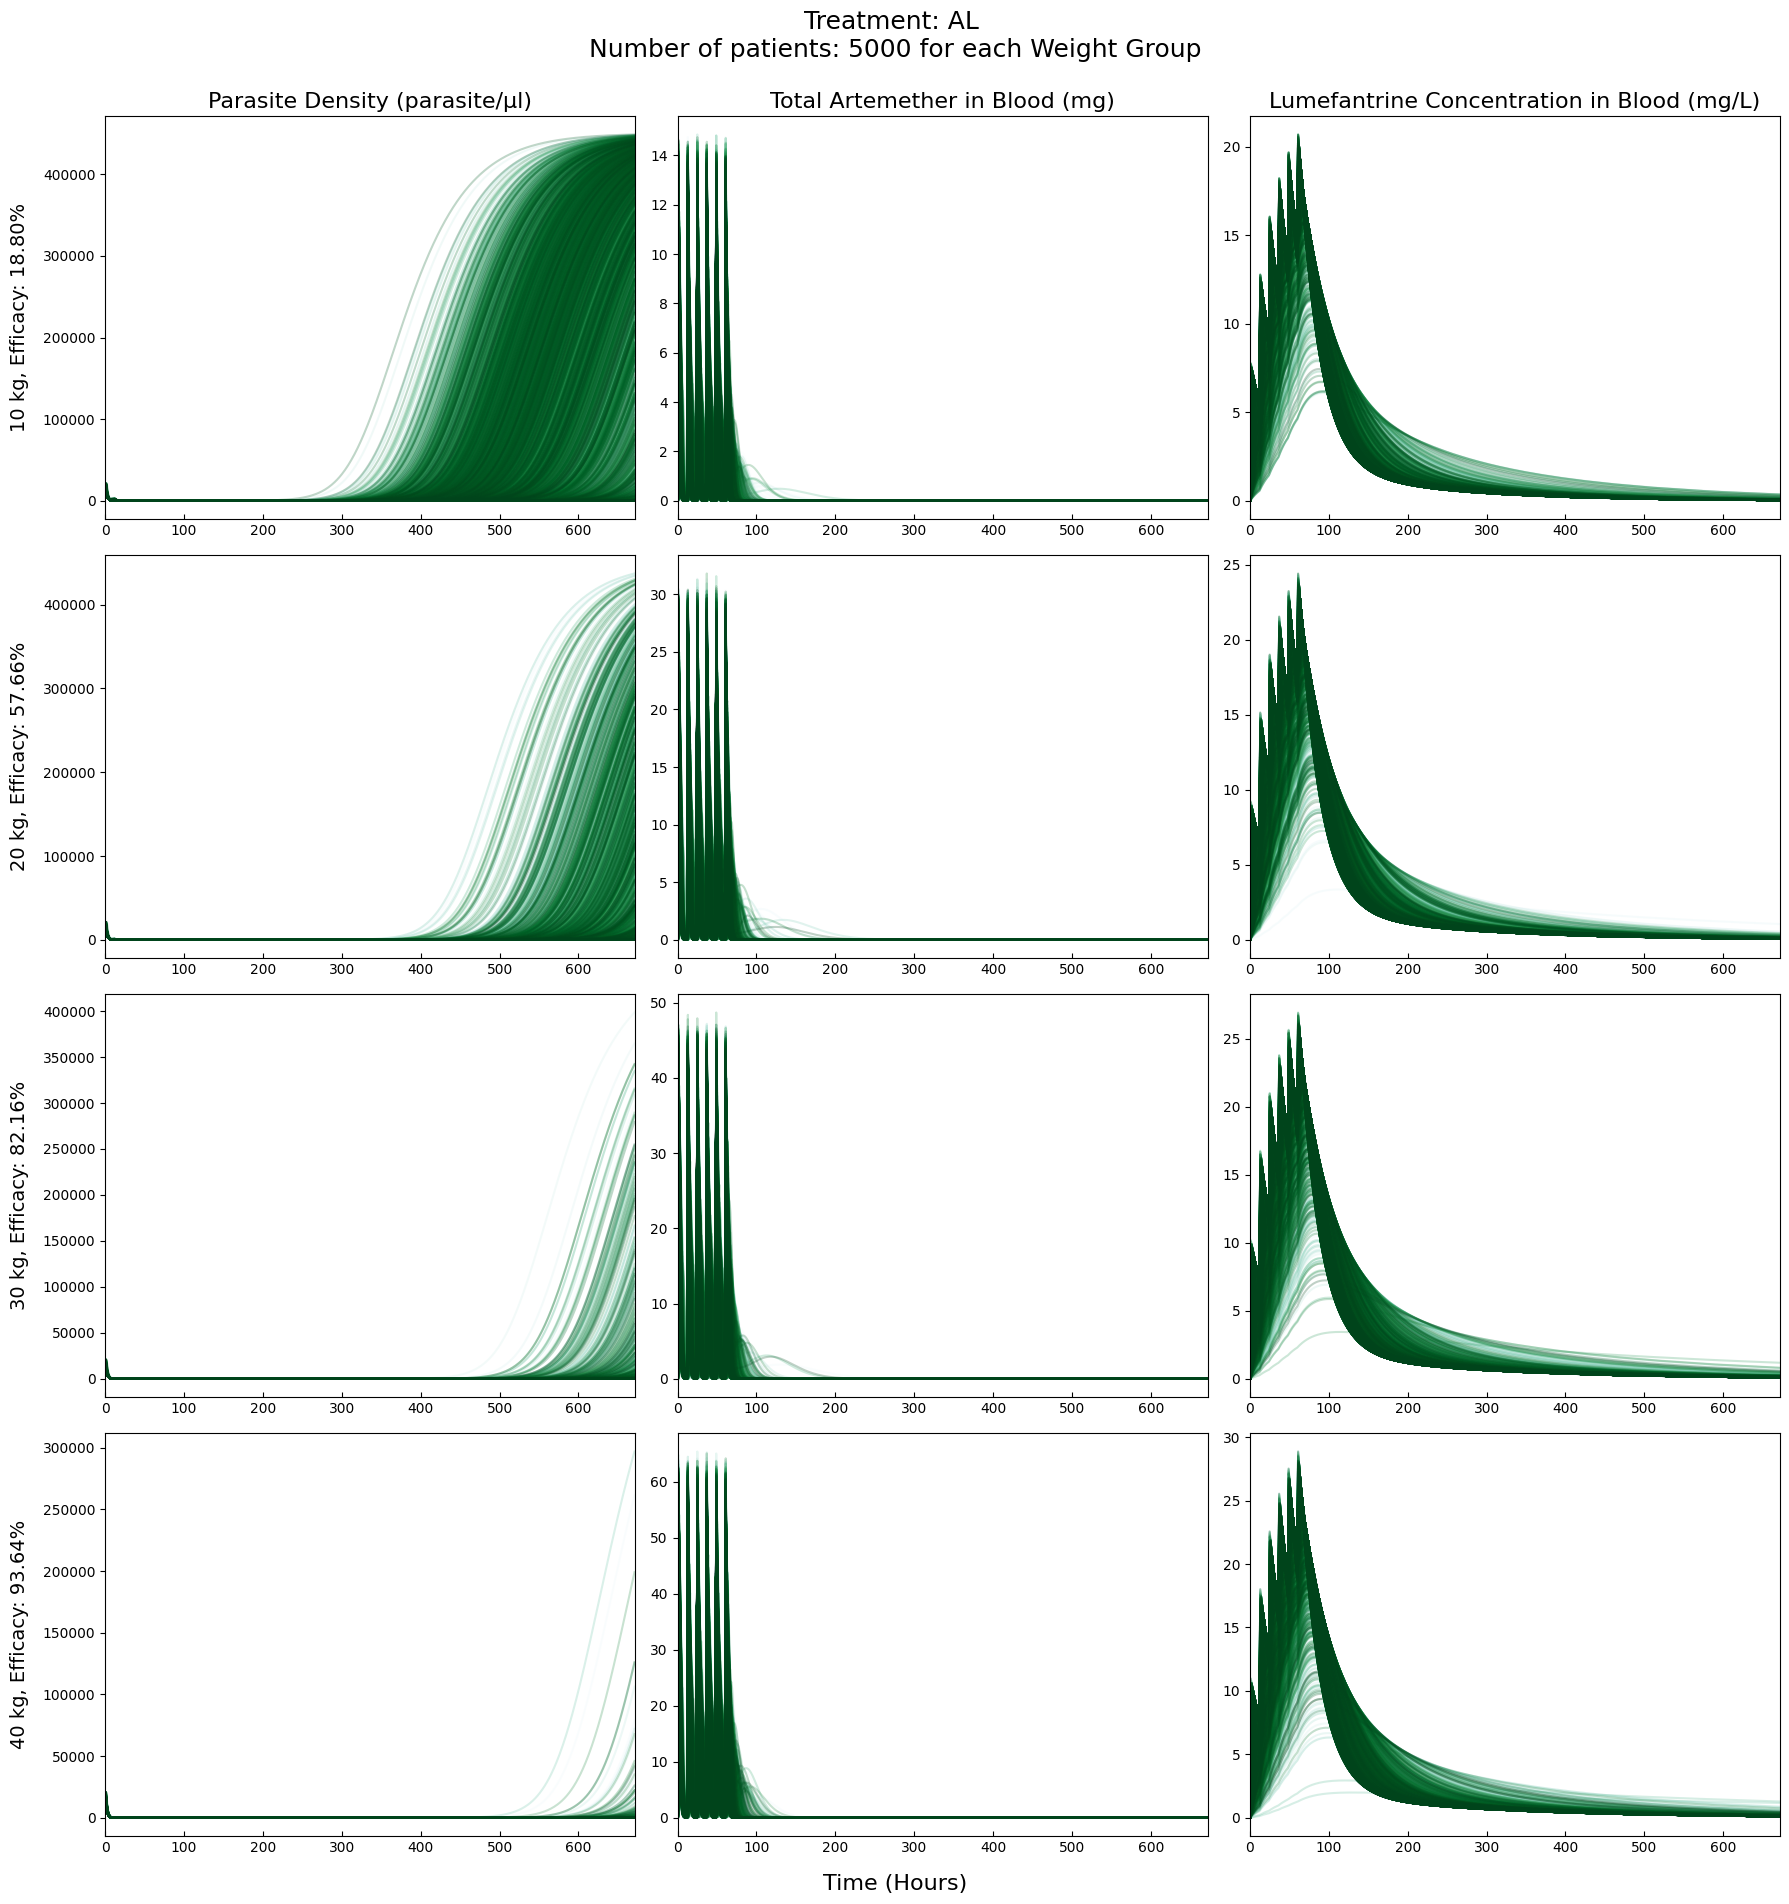

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (4 weight groups, 3 variables per group)
fig, ax = plt.subplots(4, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)

    # Plot Artemether Concentration (Column 2)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)

# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Total Artemether in Blood (mg)", "Lumefantrine Concentration in Blood (mg/L)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')
        #subplot.tick_params(axis='y', direction='in')

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights.png")
plt.show()


In [54]:
df_dict

{10:           PID   HOUR  COMP2CONC_ARTEMETHER  COMP2CONC_LUM  PARASITEDENSITY
 1           0    0.0                 0.000          0.000        20000.000
 2           0    1.0                 6.444          0.292        15297.916
 3           0    2.0                39.439          0.565         8801.930
 4           0    3.0                36.744          0.821         5070.870
 5           0    4.0                21.940          1.059         2891.307
 ...       ...    ...                   ...            ...              ...
 3359996  4999  667.0                -0.000          0.125            0.011
 3359997  4999  668.0                -0.000          0.125            0.011
 3359998  4999  669.0                -0.000          0.124            0.012
 3359999  4999  670.0                -0.000          0.123            0.013
 3360000  4999  671.0                -0.000          0.123            0.013
 
 [3360000 rows x 5 columns],
 20:           PID   HOUR  COMP2CONC_ARTEMETHER  COMP

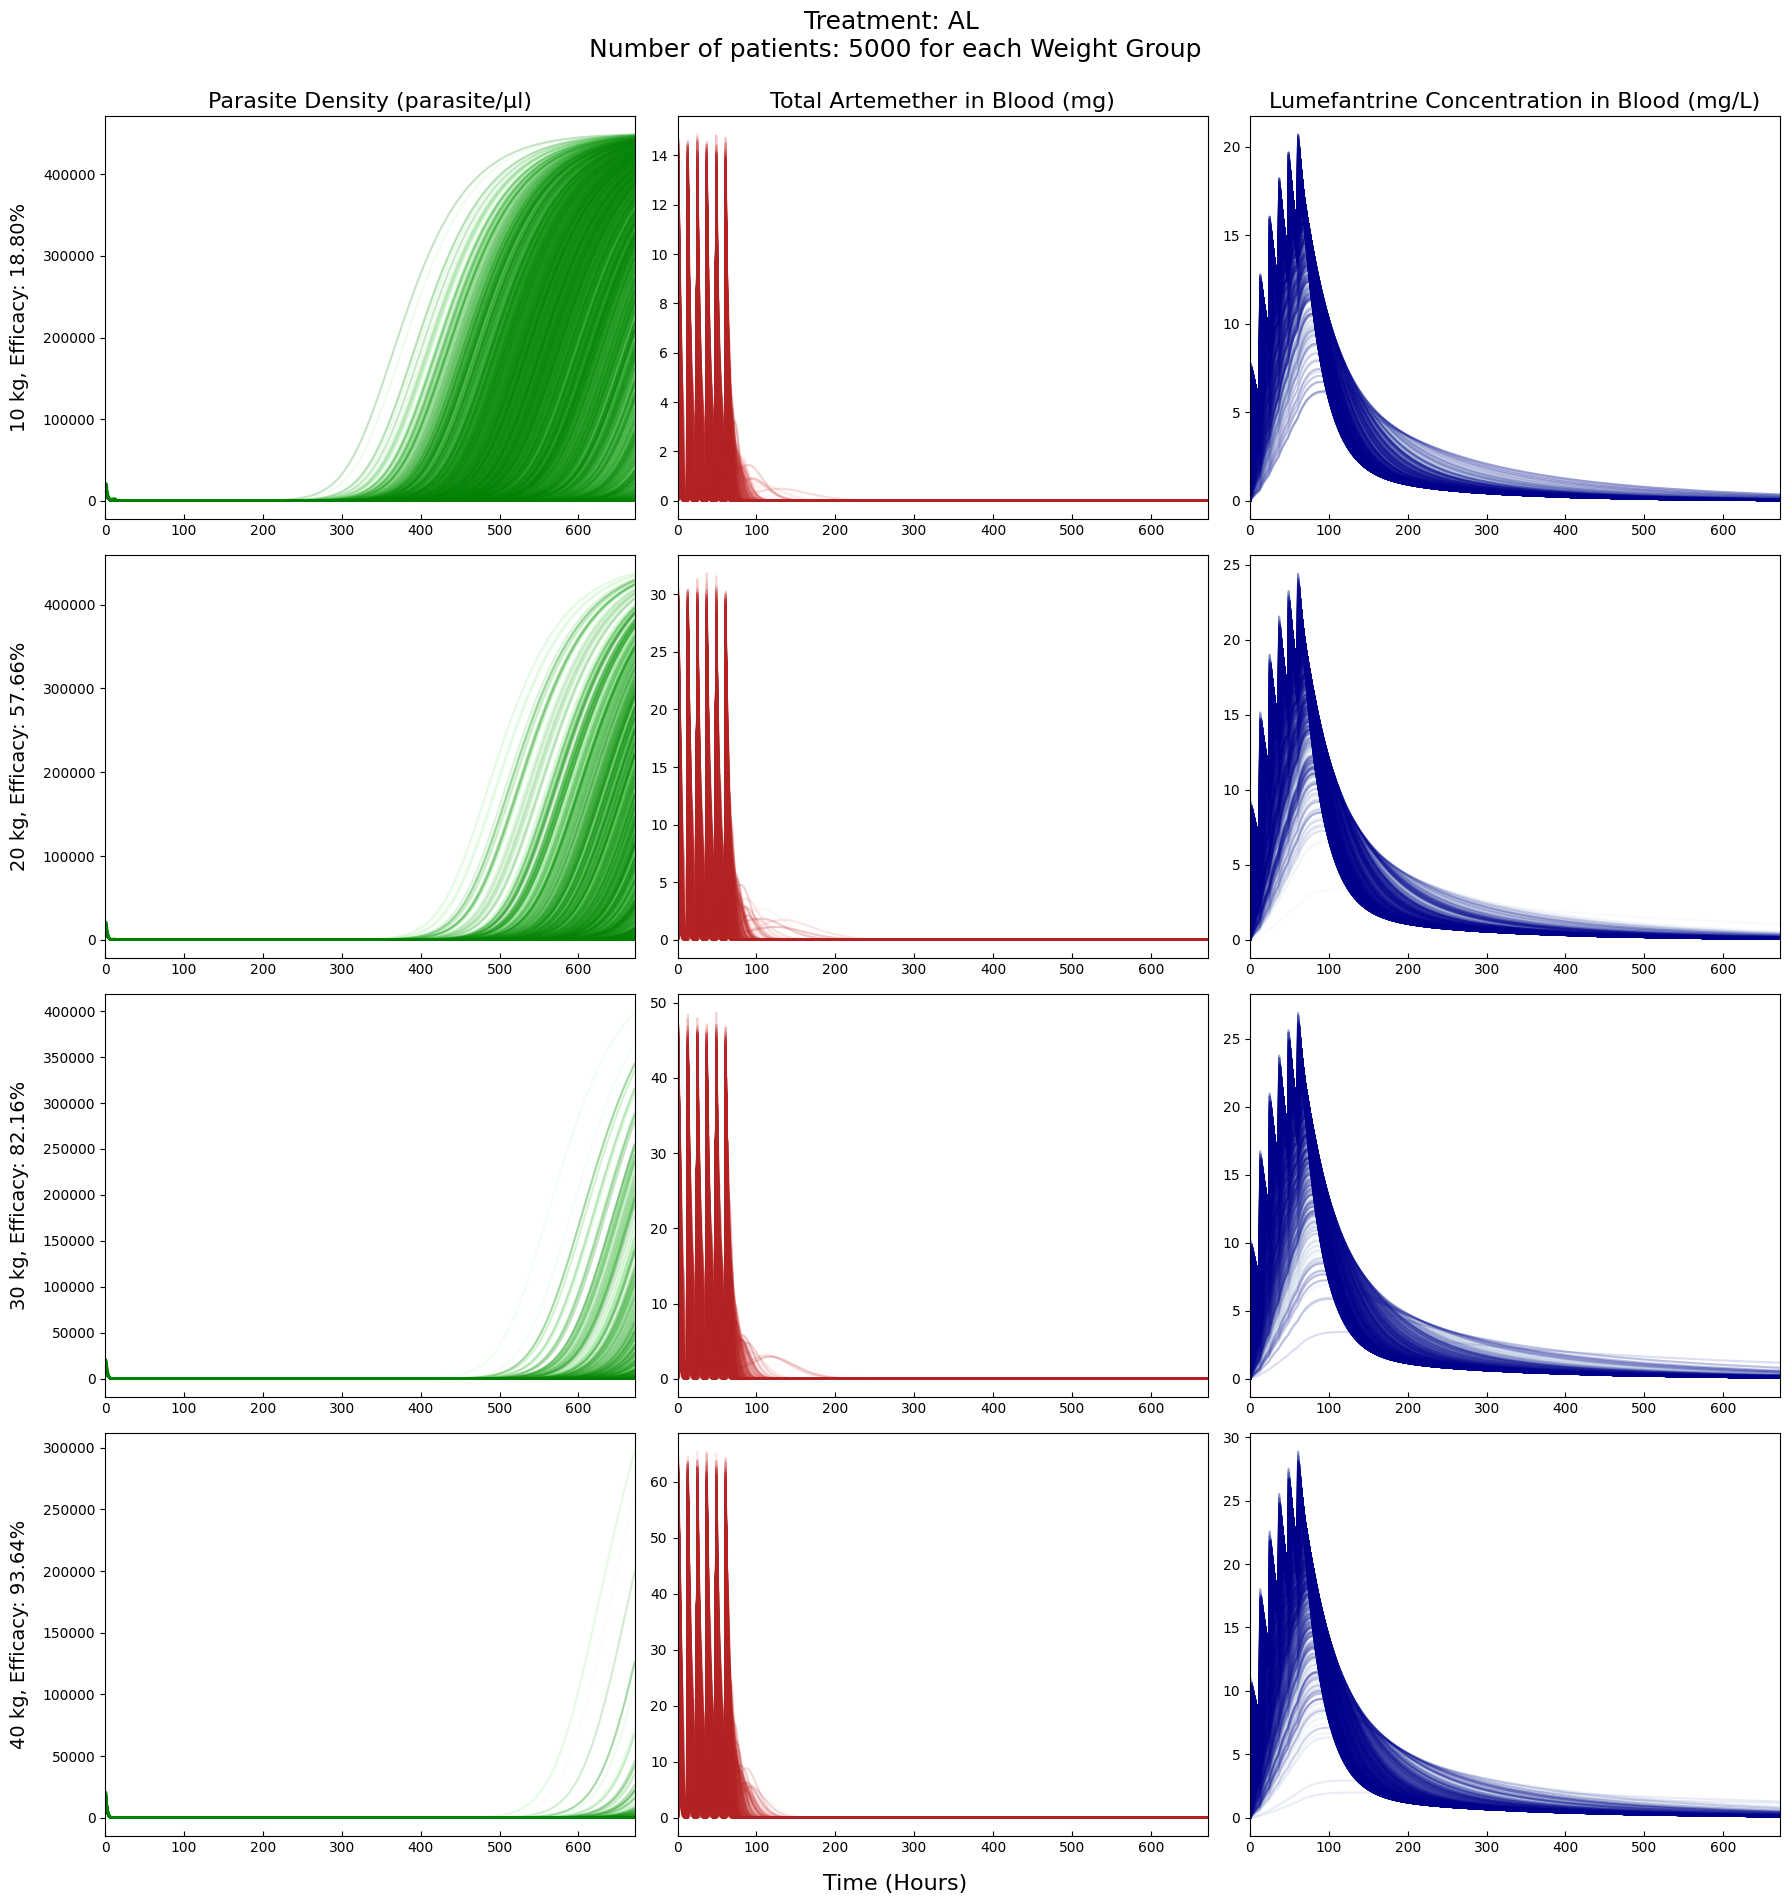

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 5x3 subplot (4 weight groups, 3 variables per group)
fig, ax = plt.subplots(4, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = green_cmap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)

    # Plot Artemether Concentration (Column 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)
   
# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Total Artemether in Blood (mg)", "Lumefantrine Concentration in Blood (mg/L)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

# Set x-ticks for all subplots
for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_multicolour.png")
plt.show()


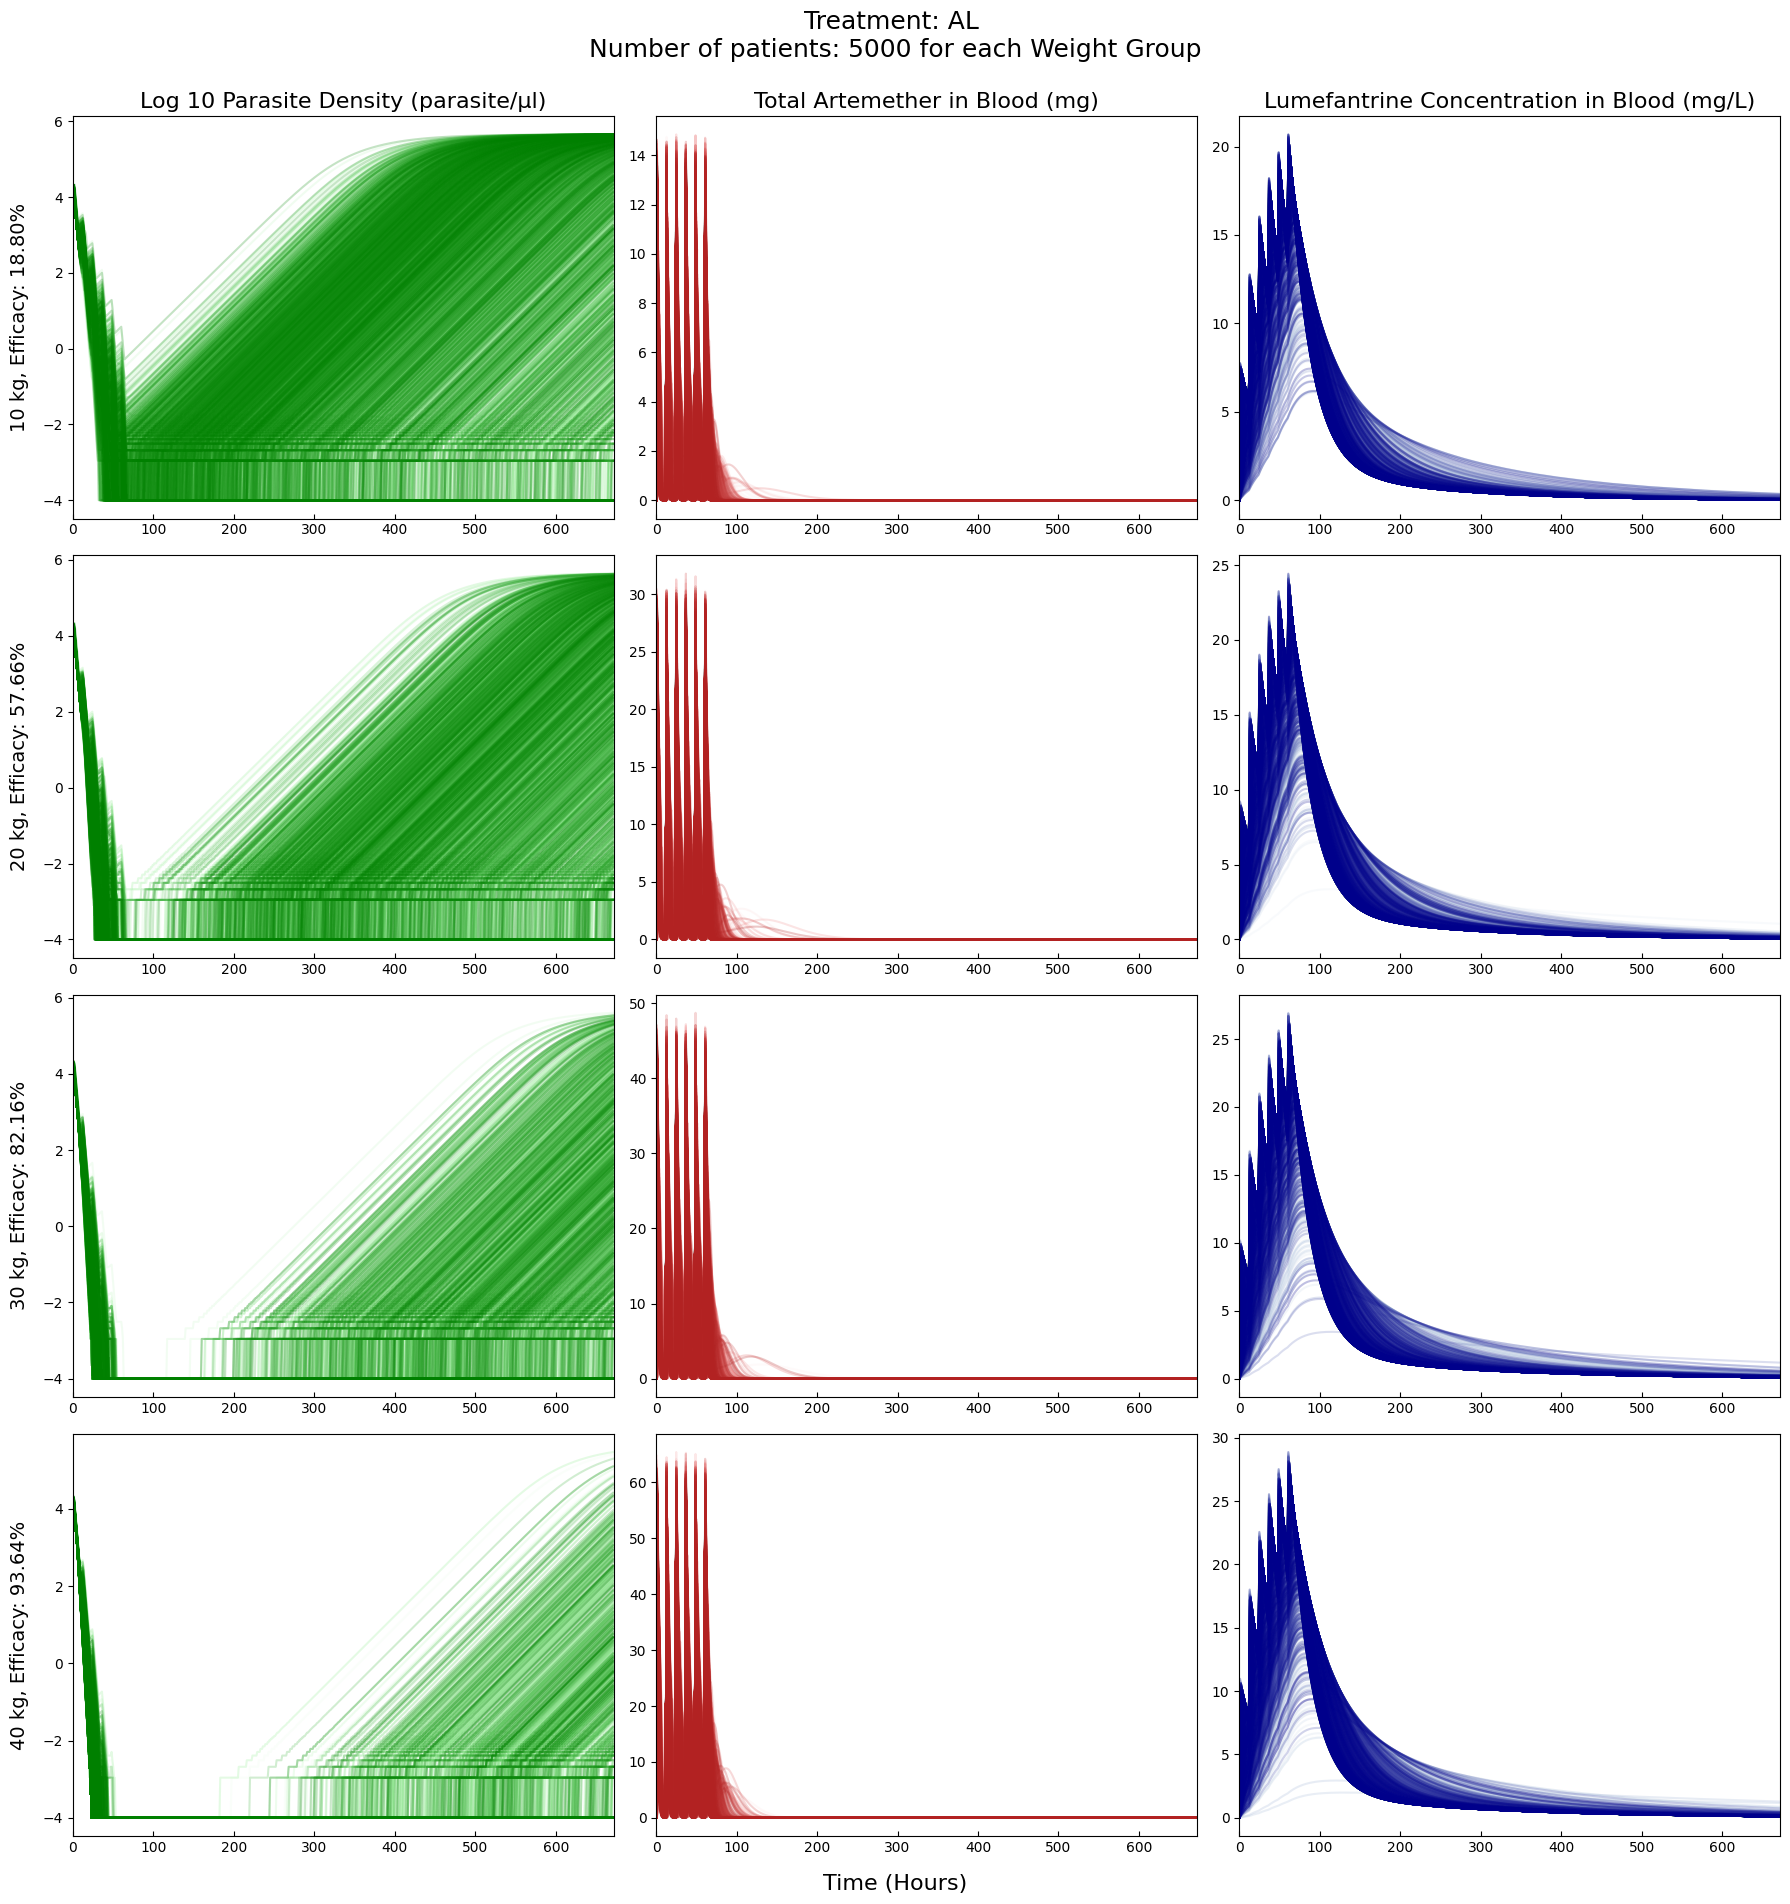

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 5x3 subplot (4 weight groups, 3 variables per group)
fig, ax = plt.subplots(4, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.0001)
        color = green_cmap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)

    # Plot Artemether Concentration (Column 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)
   
# Set **column titles** (only for the top row)
column_titles = ["Log 10 Parasite Density (parasite/μl)", "Total Artemether in Blood (mg)", "Lumefantrine Concentration in Blood (mg/L)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

# Set x-ticks for all subplots
for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_log10_multicolour.png")
plt.show()


In [185]:
pk_params_dfs = []

for i in range(1, 5):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_artemether.txt", sep=",", header=0)
    pk_params_dfs.append(pk_params)

In [186]:
type(pk_params_dfs[0])

pandas.core.frame.DataFrame

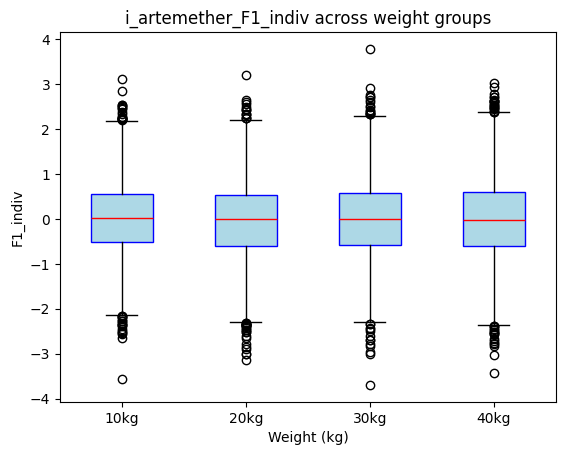

In [145]:
for i in range(1, 5):
    plt.boxplot(pk_params_dfs[i-1]["i_artemether_F1_indiv"], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks([1, 2, 3, 4], ['10kg', '20kg', '30kg', '40kg'])
plt.xlabel('Weight (kg)')
plt.ylabel('F1_indiv')
plt.title('i_artemether_F1_indiv across weight groups')
plt.savefig("F1_indiv_boxplot.png")
plt.show()

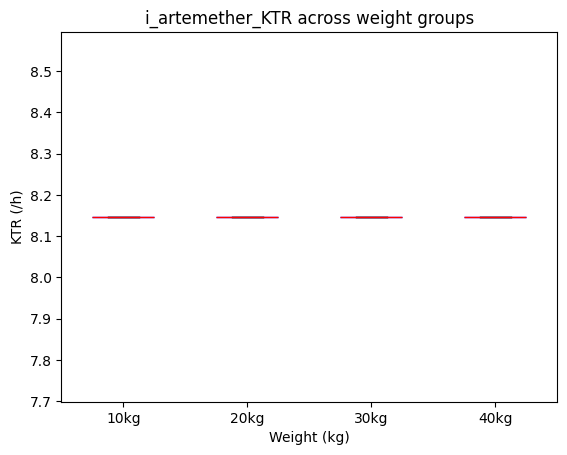

In [149]:
for i in range(1, 5):
    plt.boxplot(pk_params_dfs[i-1]["i_artemether_KTR"], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks([1, 2, 3, 4], ['10kg', '20kg', '30kg', '40kg'])
plt.xlabel('Weight (kg)')
plt.ylabel('KTR (/h)')
plt.title('i_artemether_KTR across weight groups')
plt.savefig("KTR_boxplot.png")
plt.show()

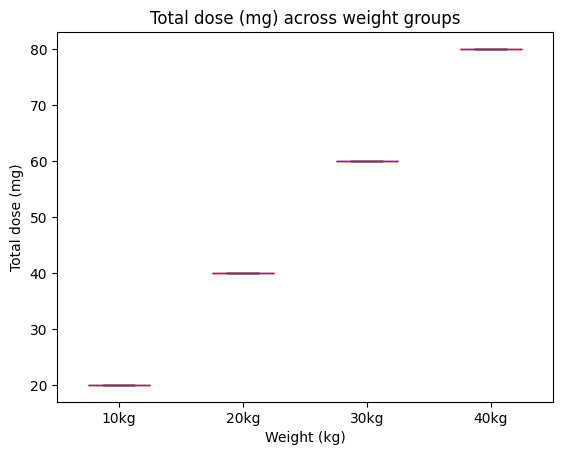

In [148]:
for i in range(1, 5):
    plt.boxplot(pk_params_dfs[i-1]["total_mg_dose_per_occassion"], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks([1, 2, 3, 4], ['10kg', '20kg', '30kg', '40kg'])
plt.xlabel('Weight (kg)')
plt.ylabel('Total dose (mg)')
plt.title('Total dose (mg) across weight groups')
plt.savefig("total_dose_boxplot.png")
plt.show()

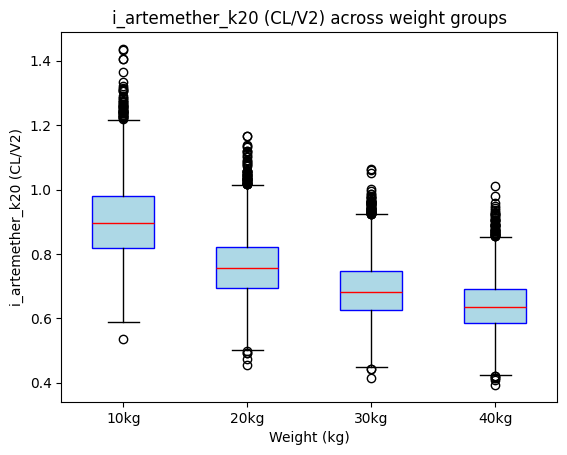

In [ ]:
for i in range(1, 5):
    plt.boxplot(pk_params_dfs[i-1][" i_artemether_k20 (CL/V2)"], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks([1, 2, 3, 4], ['10kg', '20kg', '30kg', '40kg'])
plt.xlabel('Weight (kg)')
plt.ylabel('i_artemether_k20 (CL/V2) per hour')
plt.title('i_artemether_k20 (CL/V2) across weight groups')
plt.savefig("cl_v2_boxplot.png")
plt.show()

In [187]:
for i in range(0, 4):
    pk_params_dfs[i].columns = pk_params_dfs[i].columns.str.replace(' ', '_')
    pk_params_dfs[i].columns = pk_params_dfs[i].columns.str.replace('(', '_')
    pk_params_dfs[i].columns = pk_params_dfs[i].columns.str.replace(')', '_')
    pk_params_dfs[i].columns = pk_params_dfs[i].columns.str.replace('/', '_')

In [7]:
pk_params_dfs = []

for i in range(1, 5):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_lumefantrine.txt", sep=",", header=0)
    pk_params_dfs.append(pk_params)

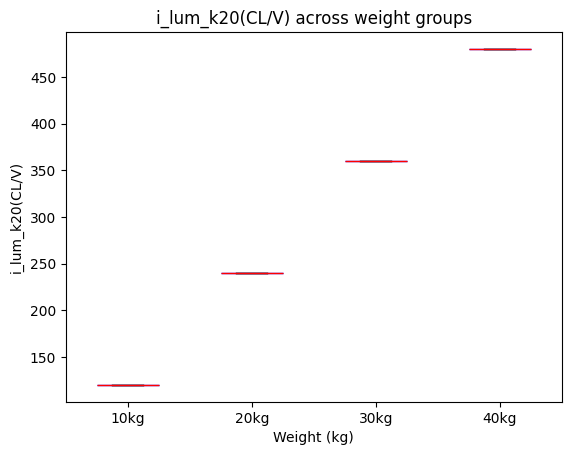

In [8]:
for i in range(1, 5):
    plt.boxplot(pk_params_dfs[i-1]["i_lum_k20(CL/V)"], positions=[i], widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))
plt.xticks([1, 2, 3, 4], ['10kg', '20kg', '30kg', '40kg'])
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_k20(CL/V)')
plt.title('i_lum_k20(CL/V) across weight groups')
plt.savefig("i_lum_k20(CLV_).png")
plt.show()

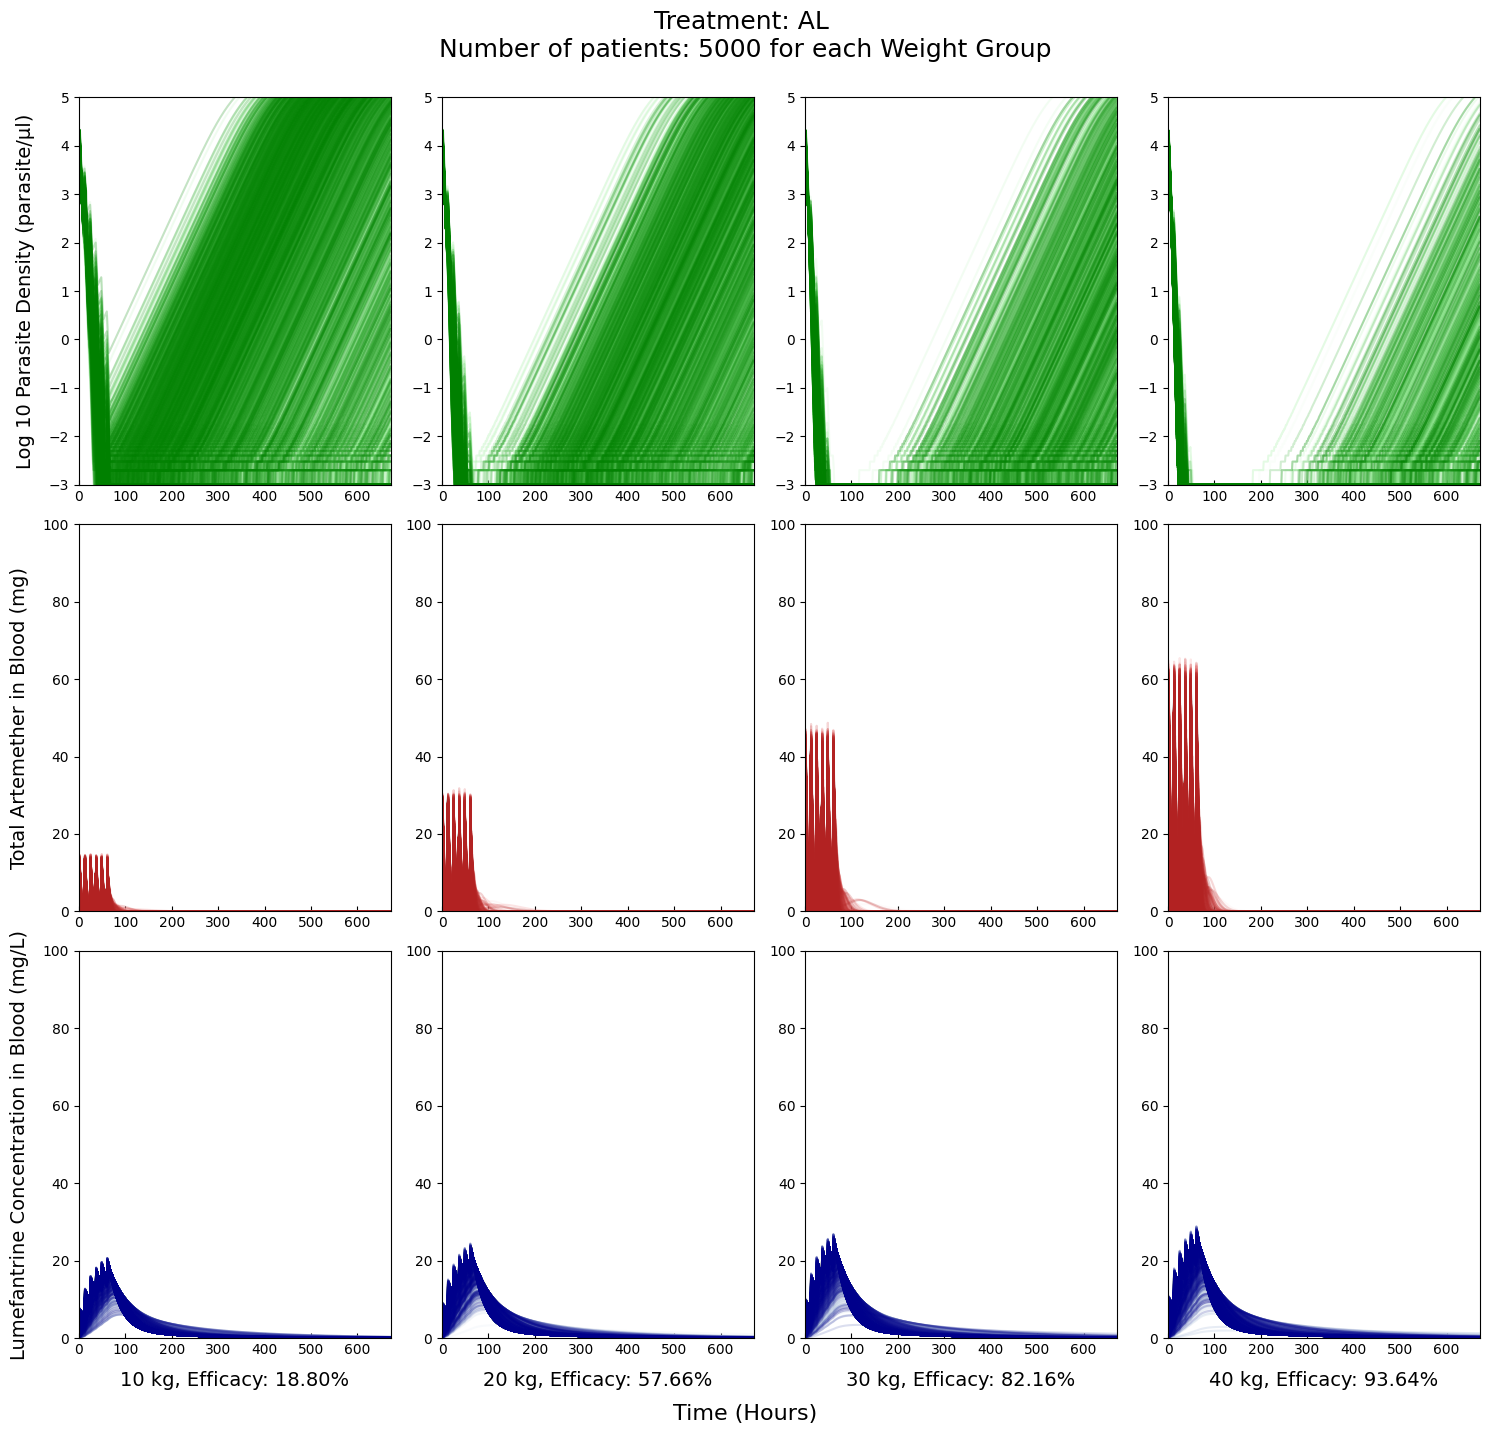

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 4:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 5x3 subplot (3 variables, 4 weightgroups)
fig, ax = plt.subplots(3, 4, figsize=(15, 15), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Row 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3, 5)  # Set y-axis limits for Parasite Density

    # Plot Artemether Concentration (Row 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 100)

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 100)

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[2, i].set_xlabel(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}%', fontsize=14, labelpad=10)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density (parasite/μl)", "Total Artemether in Blood (mg)", "Lumefantrine Concentration in Blood (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=14, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(4):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_log10_multicolour_02.png")
plt.show()
